In [8]:
# Imports
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm
import matplotlib.pyplot as plt

In [9]:
# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
print("✅ Using device:", device)

✅ Using device: cuda


In [16]:
# Dataset
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = os.listdir(image_dir)

        self.transform = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor(),
            T.Normalize([0.5], [0.5])  # Normalizing grayscale images
        ])

    def __getitem__(self, idx):
        try:
            img_name = self.image_list[idx]
            img_path = os.path.join(self.image_dir, img_name)
            mask_name = img_name.replace("slice", "mask")
            mask_path = os.path.join(self.mask_dir, mask_name)

            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                raise FileNotFoundError(f"Missing: {img_path} or {mask_path}")

            image = Image.open(img_path).convert("L")
            mask = Image.open(mask_path).convert("L")

            image = self.transform(image)
            mask = T.ToTensor()(mask)

            return image, mask

        except Exception as e:
            print(f"[❌ Dataset Error at idx {idx}]: {e}")
            return None

    def __len__(self):
        return len(self.image_list)

In [17]:
# UNet++ Model
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [18]:
class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv0_0 = ConvBlock(in_channels, features[0])
        self.conv1_0 = ConvBlock(features[0], features[1])
        self.conv2_0 = ConvBlock(features[1], features[2])
        self.conv3_0 = ConvBlock(features[2], features[3])
        self.conv4_0 = ConvBlock(features[3], features[3])
        self.conv0_1 = ConvBlock(features[0] + features[1], features[0])
        self.conv1_1 = ConvBlock(features[1] + features[2], features[1])
        self.conv2_1 = ConvBlock(features[2] + features[3], features[2])
        self.conv3_1 = ConvBlock(features[3] + features[3], features[3])
        self.conv0_2 = ConvBlock(features[0]*2 + features[1], features[0])
        self.conv1_2 = ConvBlock(features[1]*2 + features[2], features[1])
        self.conv2_2 = ConvBlock(features[2]*2 + features[3], features[2])
        self.conv0_3 = ConvBlock(features[0]*3 + features[1], features[0])
        self.conv1_3 = ConvBlock(features[1]*3 + features[2], features[1])
        self.conv0_4 = ConvBlock(features[0]*4 + features[1], features[0])
        self.final = nn.Conv2d(features[0], out_channels, 1)

    def forward(self, x):
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(self.pool(x0_0))
        x2_0 = self.conv2_0(self.pool(x1_0))
        x3_0 = self.conv3_0(self.pool(x2_0))
        x4_0 = self.conv4_0(self.pool(x3_0))
        x0_1 = self.conv0_1(torch.cat([x0_0, F.interpolate(x1_0, scale_factor=2)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, F.interpolate(x2_0, scale_factor=2)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, F.interpolate(x3_0, scale_factor=2)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, F.interpolate(x4_0, scale_factor=2)], 1))
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, F.interpolate(x1_1, scale_factor=2)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, F.interpolate(x2_1, scale_factor=2)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, F.interpolate(x3_1, scale_factor=2)], 1))
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, F.interpolate(x1_2, scale_factor=2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, F.interpolate(x2_2, scale_factor=2)], 1))
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, F.interpolate(x1_3, scale_factor=2)], 1))
        return torch.sigmoid(self.final(x0_4))


In [19]:
# Loss Function
class DiceBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCELoss()

    def forward(self, preds, targets):
        smooth = 1e-6
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
        return 1 - dice + self.bce(preds, targets)

In [20]:
def dice_score(preds, targets, threshold=0.5):
    # 🔄 Resize if needed
    if preds.shape != targets.shape:
        preds = F.interpolate(preds, size=targets.shape[2:], mode='bilinear', align_corners=False)

    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    return (2. * intersection + 1e-6) / (preds.sum() + targets.sum() + 1e-6)


In [21]:
def validate(model, loader, loss_fn):
    model.eval()
    total_loss, total_dice = 0, 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)

            # 🛠 Resize prediction if shape mismatch
            if preds.shape != masks.shape:
                preds = F.interpolate(preds, size=masks.shape[2:], mode='bilinear', align_corners=False)

            total_loss += loss_fn(preds, masks).item()
            total_dice += dice_score(preds, masks).item()

    return total_loss / len(loader), total_dice / len(loader)


In [22]:
# Load Dataset
dataset = BrainTumorDataset(
    r"C:\Users\Divya Ayush\Idea Projects\Research\brats_data\newimg\img",
    r"C:\Users\Divya Ayush\Idea Projects\Research\brats_data\newimg\mask"
)
subset = Subset(dataset, list(range(0, 300)))
val_size = int(len(subset) * 0.2)
train_size = len(subset) - val_size
train_set, val_set = random_split(subset, [train_size, val_size])

In [23]:
# DataLoaders
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)


In [24]:
import torch

# Choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()  # optional, clears any lingering cache

# Model Setup
model = UNetPlusPlus().to(device)
loss_fn = DiceBCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [33]:
train_losses, val_losses, val_dices = [], [], []


In [34]:
best_dice = 0.0  # to save the best model

for epoch in range(epochs):
    print(f"\n🔁 Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0

    for images, masks in tqdm(train_loader):
        if images is None or masks is None:
            continue

        images, masks = images.to(device), masks.to(device)
        preds = model(images)

        if preds.shape != masks.shape:
            preds = F.interpolate(preds, size=masks.shape[2:], mode='bilinear', align_corners=False)

        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    val_loss, val_dice = validate(model, val_loader, loss_fn)

    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    val_dices.append(val_dice)

    print(f"✅ Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Dice: {val_dice:.4f}")

    # Optional: Save best model
    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("💾 Saved best model")



🔁 Epoch 1/10


100%|██████████| 60/60 [00:22<00:00,  2.69it/s]


✅ Train Loss: 1.0880, Val Loss: 1.0408, Dice: 0.7613
💾 Saved best model

🔁 Epoch 2/10


100%|██████████| 60/60 [00:22<00:00,  2.72it/s]


✅ Train Loss: 1.0385, Val Loss: 1.0420, Dice: 0.5640

🔁 Epoch 3/10


100%|██████████| 60/60 [00:22<00:00,  2.67it/s]


✅ Train Loss: 1.0058, Val Loss: 1.0355, Dice: 0.5514

🔁 Epoch 4/10


100%|██████████| 60/60 [00:22<00:00,  2.68it/s]


✅ Train Loss: 0.9786, Val Loss: 0.9352, Dice: 0.8189
💾 Saved best model

🔁 Epoch 5/10


100%|██████████| 60/60 [00:22<00:00,  2.69it/s]


✅ Train Loss: 0.9497, Val Loss: 0.9022, Dice: 0.8428
💾 Saved best model

🔁 Epoch 6/10


100%|██████████| 60/60 [00:21<00:00,  2.73it/s]


✅ Train Loss: 0.9259, Val Loss: 0.8900, Dice: 0.8167

🔁 Epoch 7/10


100%|██████████| 60/60 [00:21<00:00,  2.73it/s]


✅ Train Loss: 0.8977, Val Loss: 0.8610, Dice: 0.8716
💾 Saved best model

🔁 Epoch 8/10


100%|██████████| 60/60 [00:22<00:00,  2.72it/s]


✅ Train Loss: 0.8798, Val Loss: 0.8412, Dice: 0.8212

🔁 Epoch 9/10


100%|██████████| 60/60 [00:21<00:00,  2.73it/s]


✅ Train Loss: 0.8529, Val Loss: 0.8139, Dice: 0.8706

🔁 Epoch 10/10


100%|██████████| 60/60 [00:22<00:00,  2.72it/s]


✅ Train Loss: 0.8255, Val Loss: 0.7968, Dice: 0.8611


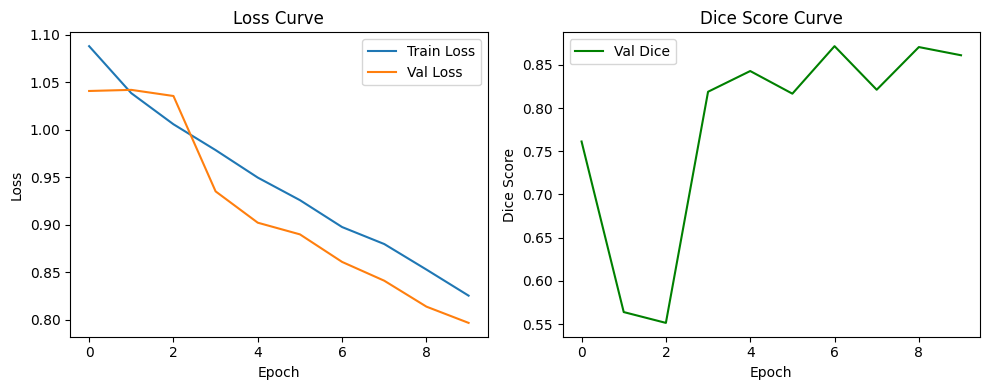

In [35]:


# Loss Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Dice Score Plot
plt.subplot(1, 2, 2)
plt.plot(val_dices, label='Val Dice', color='green')
plt.title("Dice Score Curve")
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.legend()

plt.tight_layout()
plt.show()


In [36]:
def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images_shown = 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            preds = (preds > 0.5).float()

            for i in range(images.shape[0]):
                if images_shown >= num_images:
                    return
                img = images[i].cpu().squeeze().numpy()
                mask = masks[i].cpu().squeeze().numpy()
                pred = preds[i].cpu().squeeze().numpy()

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.title("Input Image")
                plt.imshow(img, cmap='gray')

                plt.subplot(1, 3, 2)
                plt.title("Ground Truth")
                plt.imshow(mask, cmap='gray')

                plt.subplot(1, 3, 3)
                plt.title("Predicted Mask")
                plt.imshow(pred, cmap='gray')
                plt.show()

                images_shown += 1


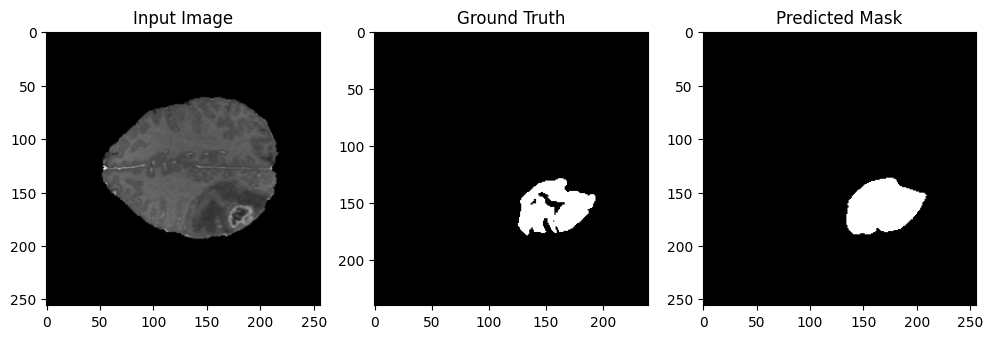

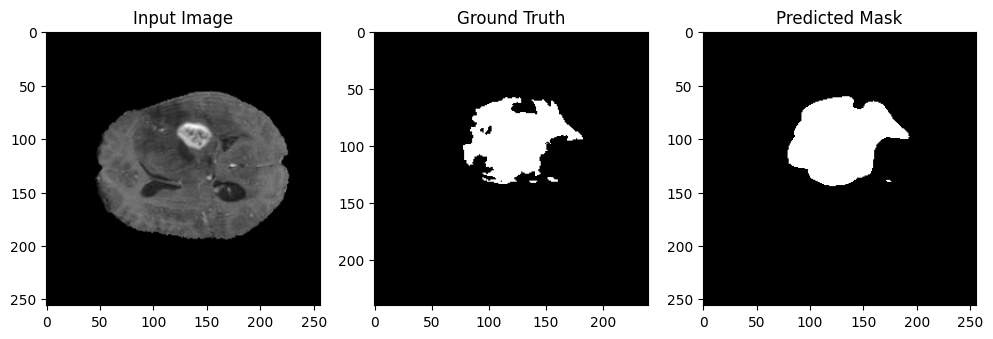

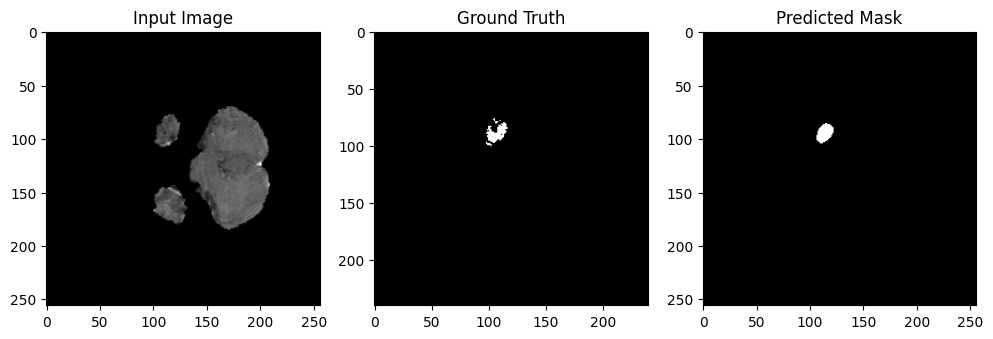

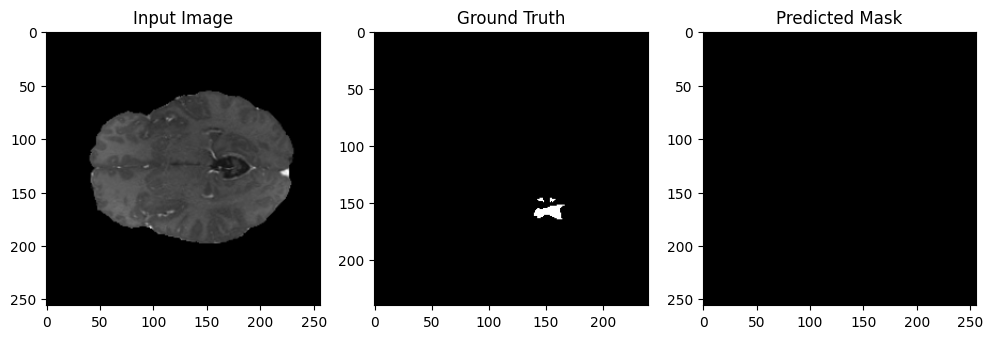

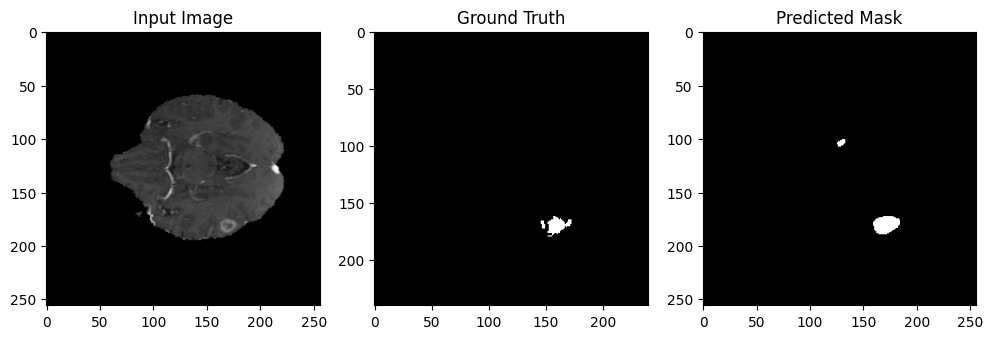

In [37]:
visualize_predictions(model, val_loader)


c:\Users\Divya Ayush\Idea Projects\Research\.venv\lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


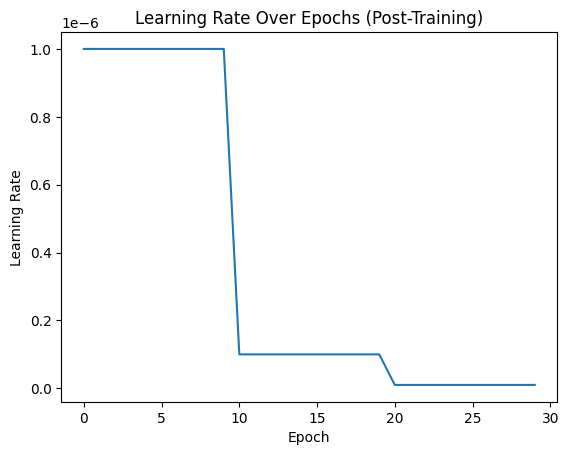

In [ ]:

scheduler = StepLR(optimizer, step_size=10, gamma=0.1) # type: ignore

# Create an empty list to track learning rate changes
lr_rates = []
epochs = 30
# Track the learning rate for the pre-trained model
for epoch in range(epochs):
    # Log the learning rate **before** stepping
    lr_rates.append(optimizer.param_groups[0]['lr'])
    scheduler.step()


# Plot the learning rate over the epochs
plt.plot(lr_rates)
plt.title("Learning Rate Over Epochs (Post-Training)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()


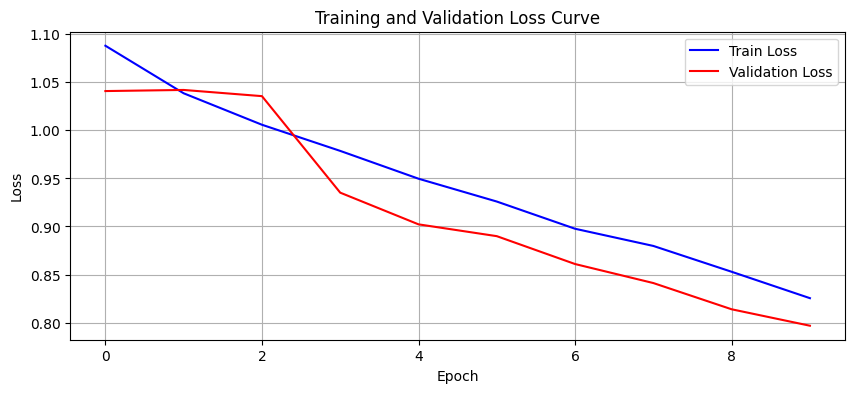

In [46]:
# Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss', color='b')
plt.plot(val_losses, label='Validation Loss', color='r')
plt.title("Training and Validation Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [57]:
# Save best model weights based on validation Dice score
if val_dice > best_dice:
    best_dice = val_dice
    torch.save(model.state_dict(), 'best_model.pth')
    print("Best model saved!")


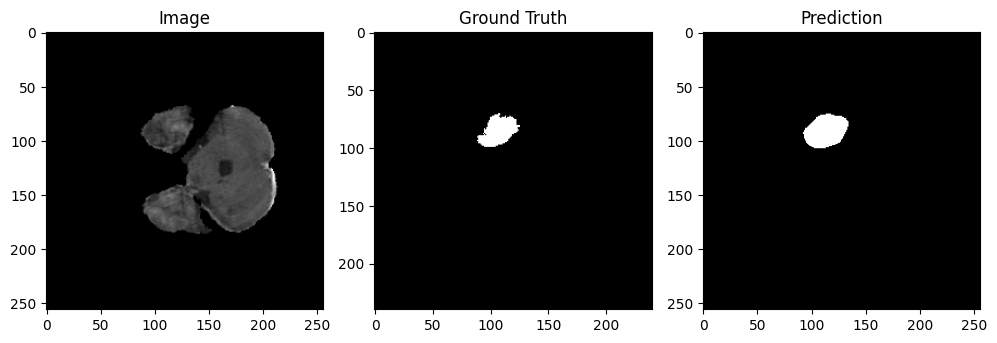

In [58]:
# 🔍 Prediction & Visualization Function
def show_prediction(model, dataset, idx=0):
    model.eval()
    image, mask = dataset[idx]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device))
        pred = (pred > 0.5).float().squeeze().cpu().numpy()
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1); plt.imshow(image.squeeze(), cmap='gray'); plt.title("Image")
    plt.subplot(1, 3, 2); plt.imshow(mask.squeeze(), cmap='gray'); plt.title("Ground Truth")
    plt.subplot(1, 3, 3); plt.imshow(pred, cmap='gray'); plt.title("Prediction")
    plt.tight_layout(); plt.show()

# Example usage after training
show_prediction(model, dataset, idx=10)